In [1]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')


In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,x,y):
        my_loss = torch.mean(torch.abs((x - y)/y))
        return  my_loss

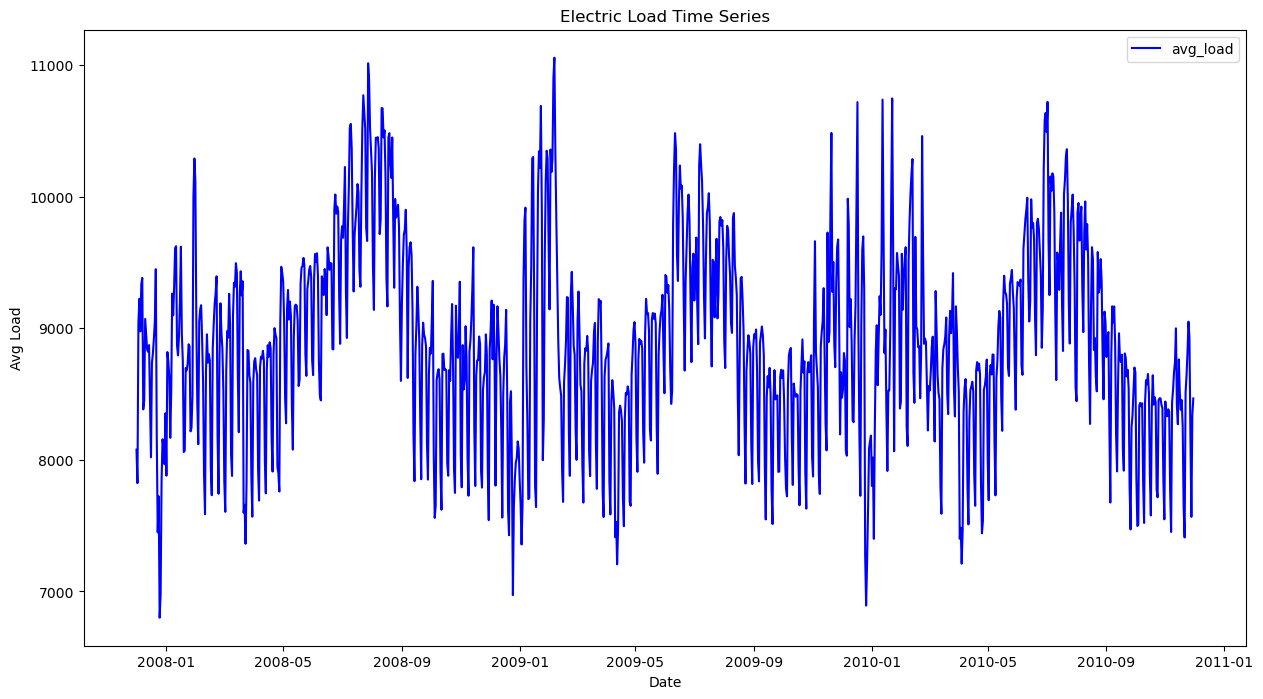

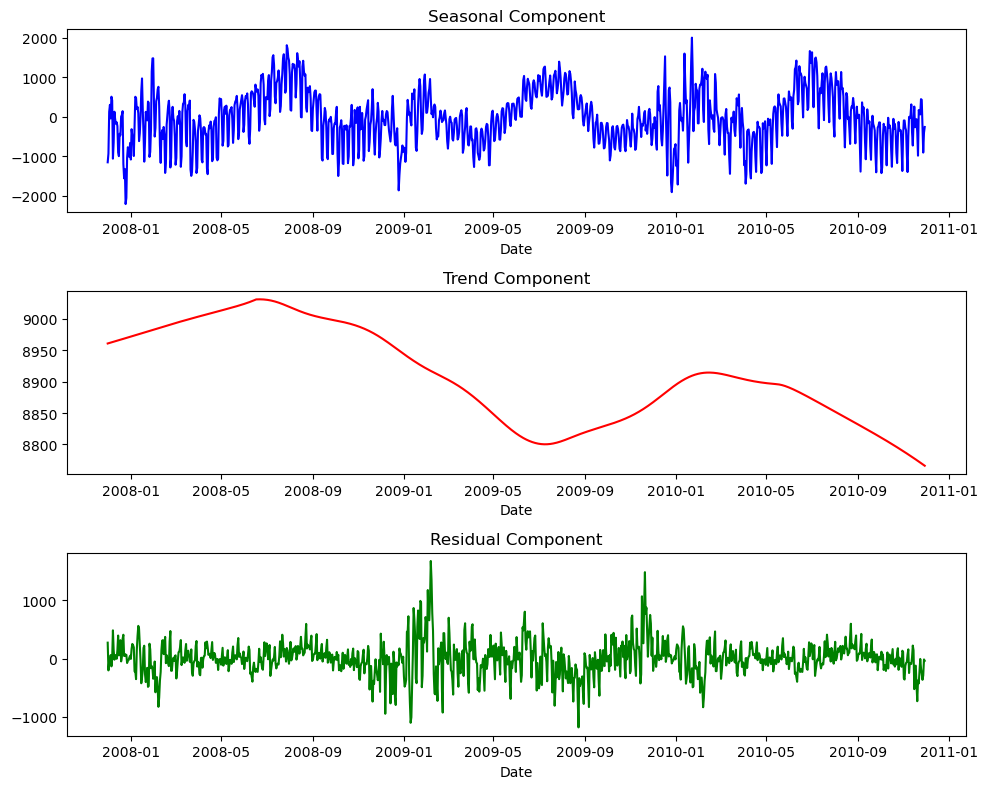

In [2]:
# STL分解只保留季节
import pandas as pd

# 读取原始数据
data = pd.read_csv('data/output_avg - 3years.csv', parse_dates=['date'], index_col='date')
fig = plt.figure(figsize=(15, 8))
# 绘制时间序列图
plt.plot(data.index, data['avg_load'], color='blue', label='avg_load')
# 添加x轴和y轴标签
plt.xlabel('Date')
plt.ylabel('Avg Load')

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

# 添加标题
plt.title('Electric Load Time Series')
# 添加图例
plt.legend()
# 显示图形
plt.show()



# 使用 STL 方法进行分解
from statsmodels.tsa.seasonal import STL
decomp = STL(data,period=365,seasonal=91,trend=399).fit()
seasonal, trend, residual = decomp.seasonal, decomp.trend, decomp.resid

# 平滑化 seasonal 和 trend
# seasonal_smoothed = seasonal.rolling(window=7, center=True).mean()
# trend_smoothed = trend.rolling(window=7, center=True).mean()
# residual  = residual.ewm(alpha=0.2, adjust=False).mean()


# 将 seasonal_smoothed、trend_smoothed 和 residual 合并为一个 DataFrame
df = pd.concat([seasonal, trend, residual], axis=1)
df.columns = ['seasonal', 'trend', 'residual']

# 对每一行进行求和
# df['all_load'] = df.sum(axis=1)
# 全
df.to_csv('data/residual/new_data（all）.csv')


import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件，将日期作为索引
data = pd.read_csv('data/residual/new_data（all）.csv', index_col='date', parse_dates=True)

# 创建子图
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# 绘制季节分量
axes[0].plot(data['seasonal'], color='blue')
axes[0].set_title('Seasonal Component')

# 绘制趋势分量
axes[1].plot(data['trend'], color='red')
axes[1].set_title('Trend Component')

# 绘制残差分量
axes[2].plot(data['residual'], color='green')
axes[2].set_title('Residual Component')

# 设置横轴标签
for ax in axes:
    ax.set_xlabel('Date')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


In [5]:
from statsmodels.tsa._stl import STL
import pandas as pd
from statsmodels.tsa.seasonal import STLDecompose

# 读取时间序列数据，假设已经存储到了 df_data 变量中
data = pd.read_csv('data/output_avg - 3years.csv', parse_dates=['date'], index_col='date')


# 使用 STL 分解
decomp = STL(data,period=365,seasonal=91,trend=399).fit()
seasonal, trend, residual = decomp.seasonal, decomp.trend, decomp.resid



df_trend = pd.concat([trend], axis=1)
df_trend.to_csv('data/STL_N-BEATS/trend.csv')
df_seasonal = pd.concat([seasonal], axis=1)
df_seasonal.to_csv('data/STL_N-BEATS/seasonal.csv')


df_residual = pd.concat([residual], axis=1)
df_residual.to_csv('data/STL_N-BEATS/residual.csv')


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# 读取 CSV 文件
df = pd.read_csv('data/STL_N-BEATS/seasonal.csv')

# 标准化处理 season 列
scaler = StandardScaler()
season_norm = scaler.fit_transform(df[['season']])

# 将标准化后的 season 数据添加到原始数据框中
df['season_norm'] = season_norm

# 将处理后的数据存储到新的 CSV 文件中
df.to_csv('data/STL_N-BEATS/seasonal_normalized.csv', index=False, columns=['date', 'season_norm'])

# # 因为原来electric曲线太过震荡所以就再进行平滑化
# df = pd.read_csv('data/STL_N-BEATS/seasonal_normalized.csv',index_col=0, parse_dates=True)
# # 计算指数加权移动平均
# alpha = 0.1
# ema = df['season_norm'].ewm(alpha=alpha, adjust=False).mean()
#
# # 将平滑后的结果保存到新的csv文件
# smoothed_df = pd.DataFrame({'smoothed_season': ema})
# smoothed_df.to_csv('data/STL_N-BEATS/smoothed_seasonal.csv')
# import pandas as pd
#
# # 读取原始数据
# data = pd.read_csv('data/STL_N-BEATS/smoothed_seasonal.csv', parse_dates=['date'], index_col='date')
# fig = plt.figure(figsize=(15, 8))
# # 绘制时间序列图
# plt.plot(data.index, data['smoothed_season'], color='blue', label='season_norm')
# # 添加x轴和y轴标签
# plt.xlabel('Date')
# plt.ylabel('Avg Load')
#
# plt.tick_params(axis='x', labelsize=10)
# plt.tick_params(axis='y', labelsize=10)
#
# # 添加标题
# plt.title('Electric Load Time Series')
# # 添加图例
# plt.legend()
# # 显示图形
# plt.show()


            season_norm
date                   
2007-12-01    -1.657935
2007-12-02    -1.333599
2007-12-03     0.221067
2007-12-04     0.477502
2007-12-05    -0.029204
684
| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=True)
     | -- TrendBlock(units=64, thetas_dim=2, backcast_length=210, forecast_length=30, share_thetas=True) at @1957328489672
     | -- TrendBlock(units=64, thetas_dim=2, backcast_length=210, forecast_length=30, share_thetas=True) at @1957328489672
     | -- TrendBlock(units=64, thetas_dim=2, backcast_length=210, forecast_length=30, share_thetas=True) at @1957328489672
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=30, backcast_length=210, forecast_length=30, share_thetas=True) at @1957352550856
     | -- SeasonalityBlock(units=64, thetas_dim=30, backcast_length=210, forecast_length=30, share_thetas=True) at @1957352550856
     | -- SeasonalityBlock(units=64, thetas_dim=30, backcast_length=210, fore

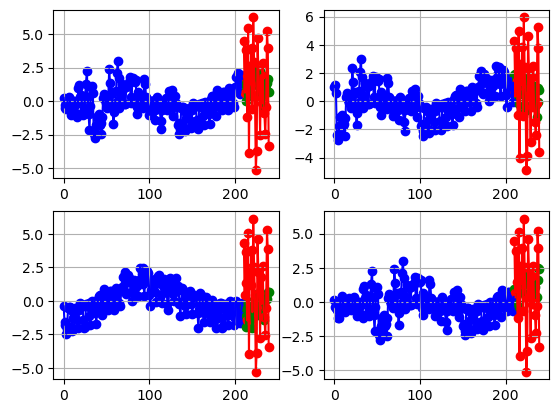

epoch = 0000, grad_step = 000043, tr_loss (epoch) = 1494.555, te_loss (epoch) = 1165.864


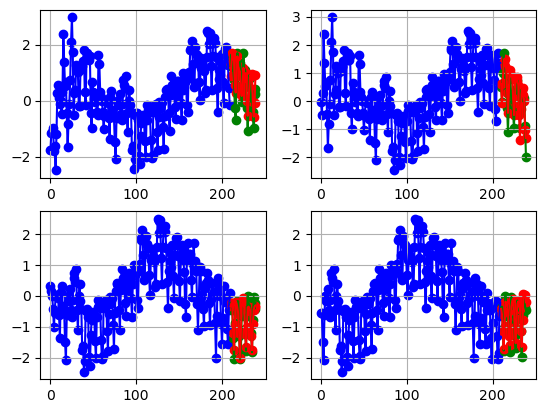

epoch = 0100, grad_step = 004343, tr_loss (epoch) = 21.744, te_loss (epoch) = 33.234


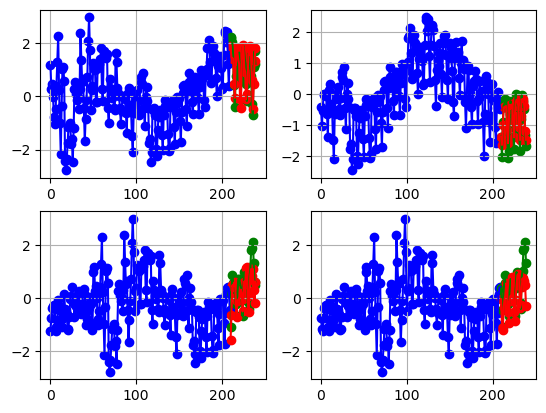

epoch = 0200, grad_step = 008643, tr_loss (epoch) = 14.673, te_loss (epoch) = 24.569


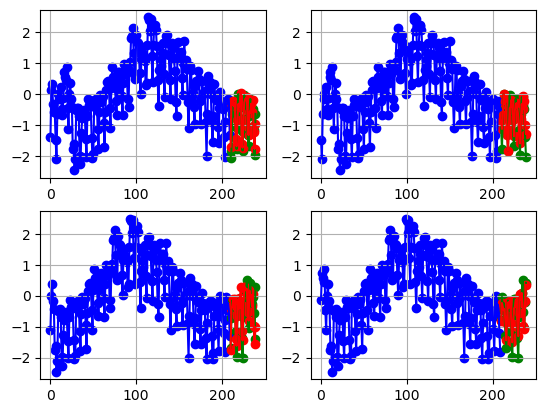

epoch = 0300, grad_step = 012943, tr_loss (epoch) = 10.714, te_loss (epoch) = 23.892


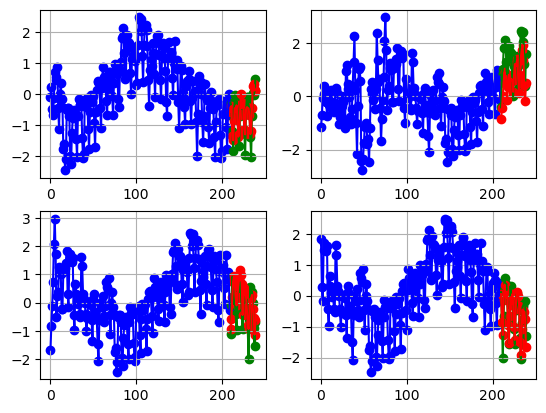

epoch = 0400, grad_step = 017243, tr_loss (epoch) = 10.219, te_loss (epoch) = 23.879


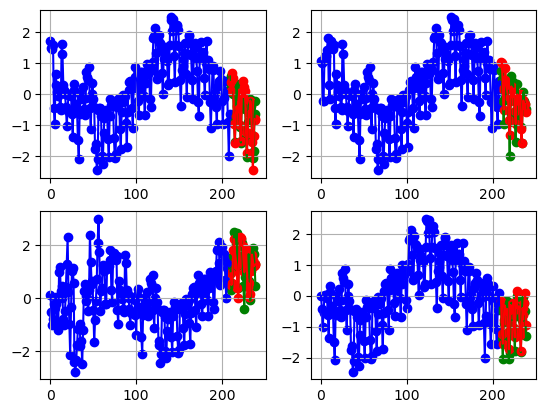

epoch = 0500, grad_step = 021543, tr_loss (epoch) = 7.090, te_loss (epoch) = 24.257


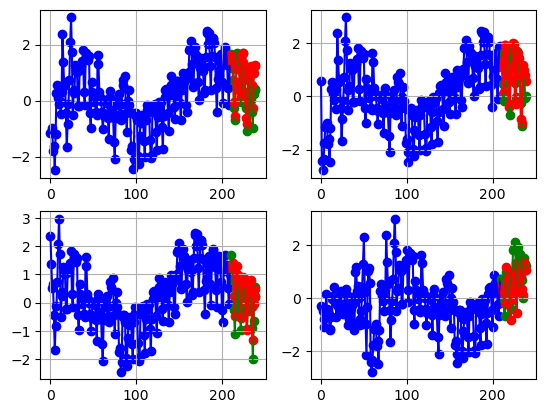

epoch = 0600, grad_step = 025843, tr_loss (epoch) = 6.192, te_loss (epoch) = 24.952


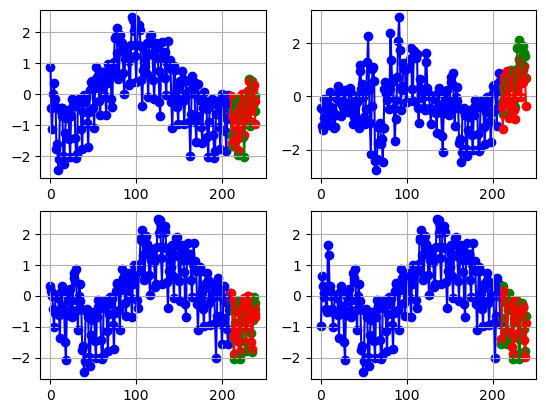

epoch = 0700, grad_step = 030143, tr_loss (epoch) = 5.651, te_loss (epoch) = 27.823


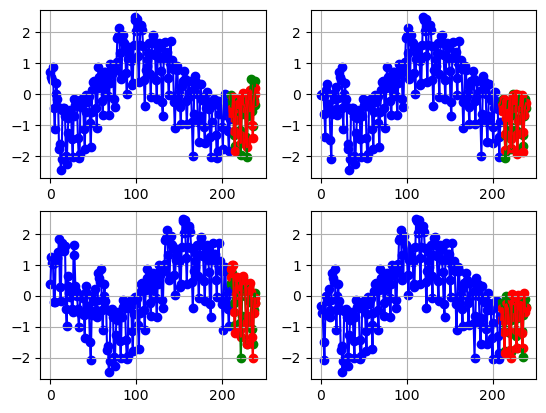

epoch = 0800, grad_step = 034443, tr_loss (epoch) = 4.128, te_loss (epoch) = 24.291


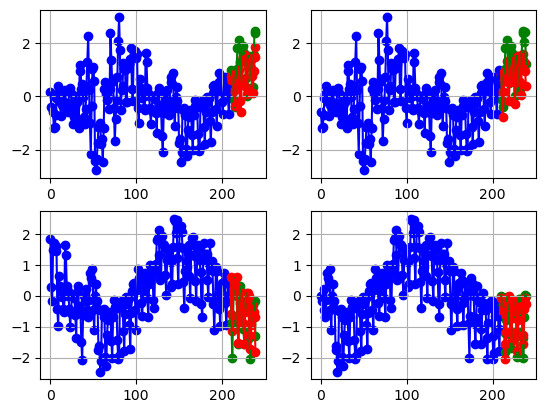

epoch = 0900, grad_step = 038743, tr_loss (epoch) = 4.157, te_loss (epoch) = 25.977
Text [-1.6193451881408691, -0.8058135509490967, -0.23409618437290192, -0.5449032187461853, -0.9463422894477844, -0.6016778349876404, -1.3511160612106323, -1.3895490169525146, -0.773974597454071, -0.3599162995815277, -0.4065791964530945, 0.5854686498641968, 0.3497529923915863, -0.3119879364967346, -0.6705402731895447, 0.2870587706565857, 0.9250454902648926, 0.619476854801178, -0.1255059540271759, -0.478860467672348, -0.519050657749176, -0.5242403745651245, -0.001138958497904241, 0.3004237413406372, -0.010336113162338734, 0.0348321869969368, -0.09464389085769653, -1.0482490062713623, -1.544906497001648, -1.3310993909835815]
TRU [-0.63899233 -0.10254708 -0.10417776 -0.3679314  -0.46784938 -1.37133093
 -2.01976162 -0.70295858  0.03014125 -0.01703187  0.09713348  0.49396278
 -0.53809154 -1.03422105 -0.19415592  0.41358804 -0.35525294 -0.25613931
 -0.05474443 -0.56232882 -1.41094852  0.28373808  0.17191565  0

In [10]:
def main():
    forecast_length = 30
    backcast_length = 7 * forecast_length
    batch_size = 16  # greater than 4 for viz

    electric = pd.read_csv('data/STL_N-BEATS/seasonal_normalized.csv', index_col=0, parse_dates=True)
    # electricO = pd.read_csv('data/STL_N-BEATS/seasonal_normalized.csv', index_col=0, parse_dates=True)

    # electricO= pd.read_csv('data/STL_N-BEATS/seasonal.csv', index_col=0, parse_dates=True)
    print(electric.head())
    # print(electricO.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.
    # electricO = electricO.values.flatten()

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=( NBeatsNet.TREND_BLOCK,NBeatsNet.SEASONALITY_BLOCK,NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        thetas_dim=(2,8,3),
        hidden_layer_units=64,
        share_weights_in_stack=True
    )

    optimiser = optim.Adam(lr=1e-4, params=net.parameters())
    # optimiser = optim.Adam(lr=0.002, params=net.parameters())


    grad_step = 0
    for epoch in range(1000):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    B = forecast.flatten()
    C= B * norm_constant

    NC = C.detach().numpy()


    NNC = NC.tolist()
    # NNC = NC.reshape(-1, 1)
    # NNC = scaler.inverse_transform(NNC)
    # NNC = NNC.ravel()
    # print('type(NNC)',type(NNC))


    Text=NNC[len(NNC)-30::]
    print('Text',Text)




    # electric = electric.tolist()
    TRU = electric[len(electric)-30::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU),type(TRU))



    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - Text[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - Text[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    torch.save(net,'STL_N-BEATS(seasonal).pth')


if __name__ == '__main__':
    main()